<a href="https://colab.research.google.com/github/vicmcl/e-commerce/blob/main/notebook_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [34]:
%reload_ext autoreload
%autoreload 2

In [35]:
from utils.preprocessing import customer_preprocessing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_json("../data/json/orders.json")

In [23]:
df[["time_since_order", "delay"]] = df[["time_since_order", "delay"]].map(
    lambda x: pd.Timedelta(x, unit="ms")
)
df

,order_id,customer_unique_id,total_payments,mean_review_score,time_since_order,delay
6511,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,89.71,1.0,0 days 00:00:00,0 days 00:00:00
68317,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,222.03,5.0,0 days 21:14:16,0 days 00:00:00
62892,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,197.55,1.0,13 days 22:34:49,0 days 00:00:00
37735,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,80.38,2.0,16 days 02:00:09,0 days 00:00:00
22190,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,137.03,1.0,18 days 08:17:15,0 days 00:00:00
...,...,...,...,...,...,...
43966,71303d7e93b399f5bcd537d124c0bcfa,0eb1ee9dba87f5b36b4613a65074337c,109.34,1.0,744 days 19:22:26,0 days 00:00:00
74448,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,0.00,1.0,762 days 05:13:40,36 days 07:47:38
49869,809a282bbd5dbcabb6f2f724fca862ec,009b0127b727ab0ba422f6d9604487c7,40.95,1.0,764 days 02:05:59,0 days 00:00:00
89489,e5fa5a7210941f7d56d0208e4e071d35,4854e9b3feff728c13ee5fc7d1547e92,75.06,1.0,772 days 17:14:44,0 days 00:00:00


# Train sets definition

In [25]:
test_delays = range(2, 7) # months
train_periods = [2, 4, 6] # months

In [26]:
train_orders = dict()
six_months = pd.Timedelta(180, unit='D')

# Extract the orders for every train period, from 6 months before the last order
for i in train_periods:
    train_period = pd.Timedelta(i * 30, unit='D')
    # Select the data points at least 6 months before the last order
    df_train = df[df["time_since_order"] > six_months]
    # Select the data points within the train period
    df_train = df_train[
        df_train["time_since_order"] < train_period + six_months
    ]
    train_orders[i] = df_train

# Test sets definition

In [28]:
test_orders = dict()
test_window = 2 # months

# Extract the orders for every 2-month test window
# from 6 to 2 months before the last order
for j in test_delays:
    # Set start and end times for the test window
    start_time = six_months - pd.Timedelta((j - 2) * 30, unit='D')
    end_time = start_time - pd.Timedelta(test_window * 30, unit='D')
    # Filter the data points in the test window
    df_test = df[df["time_since_order"] < start_time]
    df_test = df_test[df_test["time_since_order"] > end_time]
    test_orders[j] = df_test

# Scaler & imputer

In [29]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

# Aggregation by customer and standardization

In [36]:
train_customers = dict()

for key in train_orders.keys():
    tr = train_orders[key]
    train_customers[key] = customer_preprocessing(
        data = tr, imputer = imputer, scaler = scaler
    )

In [32]:
train_customers[2]

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0004bd2a26a76fe21f786e4fbd80607f,-0.125621,0.479131,0.091338,-0.881839,-0.266470
00050ab1314c0e55a6ca13cf7181fecf,-0.125621,-1.407263,0.091338,-1.715941,-0.272267
00053a61a98854899e70ed204dd4bafe,-0.125621,1.609664,-1.933485,1.176955,-0.193918
0005ef4cd20d2893f0d9fbd94d3c0d97,-0.125621,0.170268,-1.933485,0.487518,1.201279
00090324bbad0e9342388303bb71ba0a,-0.125621,-0.698091,0.766279,-0.190747,-0.133196
...,...,...,...,...,...
ffe4d6bcc48632f0bb1bedf53702cc4b,-0.125621,-0.341118,0.766279,0.766299,-0.167490
ffec10ad4229ba46818560e1c8b40a68,-0.125621,0.225228,0.766279,-0.847957,-0.198639
fff1bdd5c5e37ca79dd74deeb91aa5b6,-0.125621,0.522406,-1.933485,1.388487,1.243018


In [38]:
test_customers = dict()

for key in test_orders.keys():
    tt = test_orders[key]
    test_customers[key] = customer_preprocessing(
        tt, imputer = imputer, scaler = scaler, set_type = "test"
    )

In [39]:
test_customers[2]

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.102348,0.260650,0.631592,0.500345,0.451003
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.102348,-1.727653,-0.172740,0.671802,0.444750
000949456b182f53c18b68d6babc79c1,-0.102348,-0.404130,-0.172740,1.477739,-0.103454
000ed48ceeb6f4bf8ad021a10a3c7b43,-0.102348,-2.045347,0.631592,-0.086301,0.284322
0019e8c501c85848ac0966d45226fa1d,-0.102348,0.661801,0.631592,1.020131,-0.361224
...,...,...,...,...,...
ffe6305176b9431a3eda3cf8904d7eb7,-0.102348,-0.836096,0.000000,-1.243461,6.846688
ffe76cb2f4bb39384c432d65ece67441,-0.102348,-0.666091,0.631592,1.361813,-0.085226
ffecceca389973ef16660d58696f281e,-0.102348,-0.549441,0.631592,1.357762,-0.102232


# K-Means

In [40]:
kmeans_model = KMeans(n_clusters=5, random_state=42)

sim_data = dict()

for t_train in train_periods:
    print("Train period:", t_train, "months" )
    train_set = train_customers[t_train]

    # K-means on train_set and store in df_cluster
    train_clusters = kmeans_model.fit_predict(train_set)

    test_clusters = dict()
    for t_delay in test_delays:
        print("Delay test:", t_delay, "months")
        test_set = test_customers[t_delay].copy()

        # K-means predictions on test_set
        test_clusters[f"test_delay_{t_delay}"] = kmeans_model.predict(test_set)


    sim_data[f"train_period_{t_train}"] = (train_clusters, test_clusters)
    print("---------------------")

Train period: 2 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------
Train period: 4 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------
Train period: 6 months
Delay test: 2 months
Delay test: 3 months
Delay test: 4 months
Delay test: 5 months
Delay test: 6 months
---------------------


# Adjusted Rand Index

The **Adjusted Rand Index** (ARI) compares the results obtained from the model with the expected customer clusters. It adjusts for the chance of random cluster assignments, providing a score between 0 and 1, where 1 indicates a perfect match between the predicted and true clusters. A higher ARI value signifies better agreement and less data drift between the model's segmentation and the actual customer segments, making it a useful tool for assessing the performance and stability of customer segmentation models over time.

In [41]:
# Adjusted rand score between each train and test sets
ari = pd.DataFrame()

# Train periods: 2, 4, 6 months
for train_period in sim_data.keys():

    # Test after 2 to 6 months
    for test_delay in sim_data[train_period][1].keys():
        train_set = sim_data[train_period][0]
        test_set = sim_data[train_period][1][test_delay]

        # Number of data points
        n_sample = min(train_set.shape[0], test_set.shape[0])

        # Sample train or test sets while keeping the cluster proportions
        _, sampled_train, _, _ = train_test_split(
            train_set,
            train_set,
            test_size=n_sample - 5,
            stratify=train_set,
            random_state=42
        )
        _, sampled_test, _, _ = train_test_split(
            test_set,
            test_set,
            test_size=n_sample - 5,
            stratify=test_set,
            random_state=42
        )
        # Sort by cluster for comparison
        sampled_train = np.sort(sampled_train)
        sampled_test = np.sort(sampled_test)

        # Fill the DataFrame for adjusted rand score
        ari.loc[
            test_delay[-1],
            train_period[-1]
        ] = adjusted_rand_score(sampled_train, sampled_test)

ari = ari.astype(float).iloc[::-1]

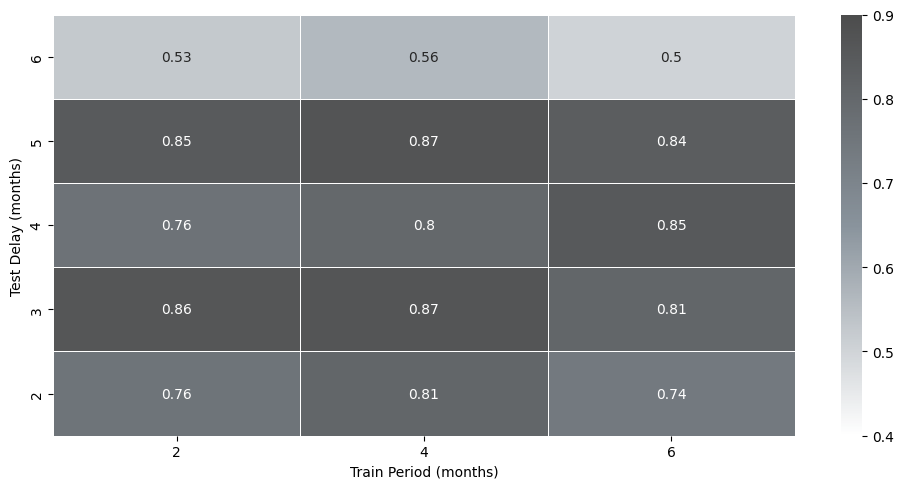

In [42]:
# Heatmap for ARI depending on train period and test delay
plt.figure(figsize=(10,5))

# Custom gradient
colors = ['#FFFFFF', '#89939C', "#4C4C4C"]

cmap = LinearSegmentedColormap.from_list('custom', colors)
cm = sns.heatmap(
    ari, cmap=cmap, annot=True, vmax=0.9, vmin=0.4,
    linewidths=0.5, linecolor='white'
)
cm.set(xlabel="Train Period (months)" , ylabel="Test Delay (months)")
plt.tight_layout()

According to the heatmap visualizing the Adjusted Rand Index (ARI) values, the best training period to obtain the most accurate and stable customer clusters over time is **4 months**.  The heatmap also shows that retraining the customer segmentation model every **3 or 5 months** yields the highest ARI scores, indicating the best results in terms of cluster stability and accuracy compared to the true customer segments.